# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/code/soln/utils.py
    !mkdir tables

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf, Cdf
from utils import decorate, savefig

## Introduction

In the previous chapter we computed distributions of sums, differences, products, and quotients.

In this chapter, we'll compute distributions of mimima and maxima use them to solve inference problems.
Then we'll look at distributions that are mixtures of other distributions, which will turn out to be particularly useful for making predictions.

But we'll start with a powerful tool for working with distributions, the cumulative distribution function.

## Cumulative Distribution Functions

So far we have been using probability mass functions to represent distributions.
A useful alternative is the **cumulative distribution function**, or CDF.

As an example, I'll use the posterior distribution from the Euro problem, which we computed in Chapter 3.

Here's the uniform prior we started with.

In [4]:
hypos = np.linspace(0, 1, 101)
pmf = Pmf(1, hypos)
data = 140, 250

And here's the update.

In [5]:
from scipy.stats import binom

def update_binomial(pmf, data):
    """Update the PMF using the binomial distribution.
    
    pmf: Pmf representing the prior
    data: tuple of integers k and n
    """
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()

In [6]:
update_binomial(pmf, data)

The CDF is the cumulative sum of the PMF, so we can compute it like this:

In [7]:
cumulative = pmf.cumsum()

Here's what it looks like.

In [8]:
def decorate_euro(title):
    decorate(xlabel='Proportion of heads (x)',
             ylabel='Probability',
             title=title)

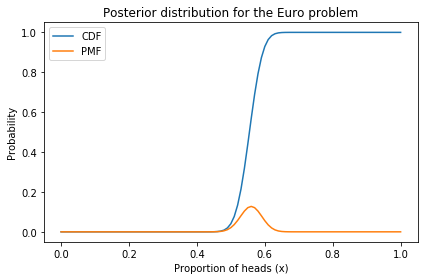

In [9]:
cumulative.plot(label='CDF')
pmf.plot(label='PMF')
decorate_euro(title='Posterior distribution for the Euro problem')
savefig('fig06-01')

The range of the CDF is always from 0 to 1, in contrast with the PMF, where the maximum can be any probability.

The result is a Pandas Series, so we can use the bracket operator to select an element:

In [10]:
cumulative[0.61]

0.9638303193984253

The result is about 0.96, which means that the total probability of all quantities less than or equal to 0.61 is 96%.

To go the other way --- to look up a probability and get the corresponding quantile --- we can use interpolation:

In [11]:
from scipy.interpolate import interp1d

ps = cumulative.values
qs = cumulative.index

interp = interp1d(ps, qs)
interp(0.96)

array(0.60890171)

The result is about 0.61, so that confirms that the 96th percentile of this distribution is 0.61.

`empiricaldist` provides a class called `Cdf` that represents a cumulative distribution function.
Given a `Pmf`, you can compute a `Cdf` like this:

In [12]:
cdf = pmf.make_cdf()

`make_cdf` uses `np.cumsum` to compute the cumulative sum of the probabilities.

You can use brackets to select an element from a `Cdf`:

In [13]:
cdf[0.61]

0.9638303193984253

But if you look up a quantity that's not in the distribution, you get a `KeyError`.


In [14]:
try:
    cdf[0.615]
except KeyError as e:
    print('KeyError')

KeyError


You can also call a `Cdf` as a function, using parentheses.
If the argument does not appear in the `Cdf`, it interpolates between quantities.

In [15]:
cdf(0.615)

array(0.96383032)

Going the other way, you can use `quantile` to look up a cumulative probability and get the corresponding quantity:


In [16]:
cdf.quantile(0.9638303)

array(0.61)

`Cdf` also provides `credible_interval`, which computes a credible interval that contains the given probability:


In [17]:
cdf.credible_interval(0.9)

array([0.51, 0.61])

CDFs and PMFs are equivalent in the sense that they contain the
same information about the distribution, and you can always convert
from one to the other.
Given a `Cdf`, you can get the equivalent `Pmf` like this:

In [18]:
pmf = cdf.make_pmf()

`make_pmf` uses `np.diff` to compute differences between consecutive cumulative probabilities.

One reason `Cdf` objects are useful is that they compute quantiles efficiently.
Another is that they make it easy to compute the distribution of a maximum or minimum, as we'll see in the next section.

## Best Three of Four

In *Dungeons & Dragons*, each character has six attributes: strength, intelligence, wisdom, dexterity, constitution, and charisma.

To generate a new character, players roll four 6-sided dice for each attribute and add up the best three.
For example, if I roll for strength and get 1, 2, 3, 4 on the dice, my character's strength would be 9.

As an exercise, let's figure out the distribution of these attributes.
Then, for each character, we'll figure out the distribution of their best attribute.

In the previous notebook, we computed the distribution of the sum of three dice like this:

In [19]:
def make_die(sides):
    """Pmf that represents a die with the given number of sides.
    
    sides: int
    
    returns: Pmf
    """
    outcomes = np.arange(1, sides+1)
    die = Pmf(1/sides, outcomes)
    return die

In [20]:
def add_dist_seq(seq):
    """Distribution of sum of quantities from PMFs.
    
    seq: sequence of Pmf objects
    
    returns: Pmf
    """
    total = seq[0]
    for other in seq[1:]:
        total = total.add_dist(other)
    return total

In [21]:
die = make_die(6)
dice = [die] * 3

In [22]:
pmf_3d6 = add_dist_seq(dice)

Here's what that distribution looks like:

In [23]:
def decorate_dice(title=''):
    decorate(xlabel='Outcome',
             ylabel='PMF',
             title=title)

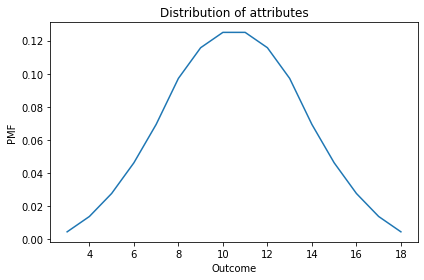

In [24]:
pmf_3d6.plot()
decorate_dice('Distribution of attributes')

But if we roll four dice and add up the best three, computing the distribution of the sum is a bit more complicated.
I'll estimate the distribution by simulating 10,000 rolls.

First I'll create an array of random values from 1 to 6, with 10,000 rows and 4 columns:

In [25]:
n = 10000
a = np.random.randint(1, 7, size=(n, 4))

To find the best three outcomes in each row, I'll sort along `axis=1`, which means across the columns.

In [26]:
a.sort(axis=1)

Finally, I'll select the last three columns and add them up.

In [27]:
t = a[:, 1:].sum(axis=1)

Now `t` is an array with a single column and 10,000 rows.
We can compute the PMF of the values in `t` like this:

In [28]:
pmf_4d6 = Pmf.from_seq(t)

The following figure shows the distribution of the sum of three dice, `pmf_3d6`, and the distribution of the best three out of four, `pmf_4d6`.

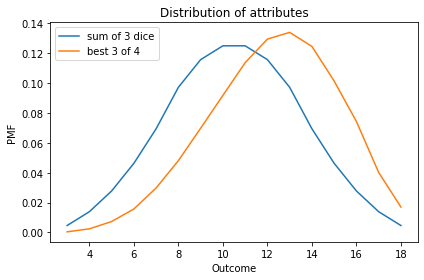

In [29]:
pmf_3d6.plot(label='sum of 3 dice')
pmf_4d6.plot(label='best 3 of 4')

decorate_dice('Distribution of attributes')
savefig('fig06-02')

As you might expect, choosing the best three out of four tends to yield higher values.

Next we'll find the distribution for the maximum of six attributes, each the sum of the best three of four dice.

## Maximum

To compute the distribution of a maximum or minimum, we can make good use of the cumulative distribution function.
First, I'll compute the `Cdf` of the best three of four distribution:

In [30]:
cdf_4d6 = pmf_4d6.make_cdf()

Recall that `Cdf(x)` is the sum of probabilities for quantities less than or equal to `x`.
Equivalently, it is the probability that a random value chosen from the distribution is less than or equal to `x`.

Now suppose I draw 6 values from this distribution.
The probability that all 6 of them are less than or equal to `x` is `Cdf(x)` raised to the 6th power, which we can compute like this:

In [31]:
cdf_4d6**6

3     4.096000e-21
4     4.818903e-16
5     1.061520e-12
6     2.949295e-10
7     2.954260e-08
8     1.243577e-06
9     2.727702e-05
10    3.486772e-04
11    2.963707e-03
12    1.728804e-02
13    7.034590e-02
14    2.037567e-01
15    4.291597e-01
16    7.022916e-01
17    9.022380e-01
18    1.000000e+00
dtype: float64

If all 6 values are less than or equal to `x`, that means that their maximum is less than or equal to `x`.
So the result is the CDF of their maximum.
We can convert it to a `Cdf` object, like this:

In [32]:
from empiricaldist import Cdf

cdf_max6 = Cdf(cdf_4d6**6)

And compute the equivalent `Pmf` like this:

In [33]:
pmf_max6 = cdf_max6.make_pmf()

The following figure shows the result.

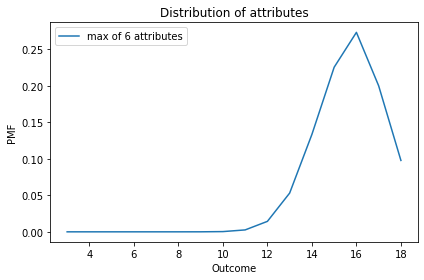

In [34]:
pmf_max6.plot(label='max of 6 attributes')

decorate_dice('Distribution of attributes')

Most characters have at least one attribute greater than 12; almost 10\% of them have an 18.

The following figure shows the CDFs for the three distributions we have computed.

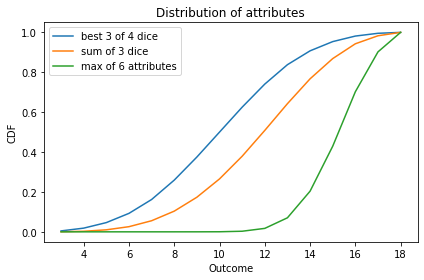

In [35]:
cdf_3d6 = pmf_3d6.make_cdf()
cdf_3d6.plot(label='best 3 of 4 dice')

cdf_4d6 = pmf_4d6.make_cdf()
cdf_4d6.plot(label='sum of 3 dice')

cdf_max6.plot(label='max of 6 attributes')

decorate_dice('Distribution of attributes')
plt.ylabel('CDF');

`Pmf` and `Cdf` provide `max_dist`, which does the same computation.
We can compute the `Pmf` of the maximum like this:

In [36]:
pmf_max_dist6 = pmf_4d6.max_dist(6)

And the `Cdf` of the maximum like this:


In [37]:
cdf_max_dist6 = cdf_4d6.max_dist(6)

And we can confirm that the differences are small.

In [38]:
np.max(np.abs(pmf_max_dist6 - pmf_max6))

0.0

In [39]:
np.max(np.abs(cdf_max_dist6 - cdf_max6))

0.0

In the next section we'll find the distribution of the minimum.
The process is similar, but a little more complicated.
See if you can figure it out before you go on.

## Minimum

In the previous section we computed the distribution of a character's best attribute.
Now let's compute the distribution of the worst.

To compute the distribution of the minimum, we'll use the **complementary CDF**, which we can compute like this:

In [40]:
prob_gt = 1 - cdf_4d6
prob_gt

3     0.9996
4     0.9972
5     0.9899
6     0.9742
7     0.9444
8     0.8963
9     0.8265
10    0.7347
11    0.6210
12    0.4915
13    0.3575
14    0.2329
15    0.1315
16    0.0572
17    0.0170
18    0.0000
dtype: float64

As the variable name suggests, the complementary CDF is the probability that a value from the distribution is greater than `x`.
If we draw 6 values from the distribution, the probability that all 6 exceed `x` is:

In [41]:
prob_gt6 = prob_gt**6
prob_gt6

3     9.976024e-01
4     9.833172e-01
5     9.409097e-01
6     8.548477e-01
7     7.094730e-01
8     5.184661e-01
9     3.187551e-01
10    1.572752e-01
11    5.735214e-02
12    1.409747e-02
13    2.087643e-03
14    1.595941e-04
15    5.170762e-06
16    3.502484e-08
17    2.413757e-11
18    0.000000e+00
dtype: float64

If all 6 exceed `x`, that means their minimum exceeds `x`, so `prob_gt6` is the complementary CDF of the minimum.
And that means we can compute the CDF of the minimum like this:

In [42]:
prob_le6 = 1-prob_gt6
prob_le6

3     0.002398
4     0.016683
5     0.059090
6     0.145152
7     0.290527
8     0.481534
9     0.681245
10    0.842725
11    0.942648
12    0.985903
13    0.997912
14    0.999840
15    0.999995
16    1.000000
17    1.000000
18    1.000000
dtype: float64

The result is a Pandas Series that represents the CDF of the minimum of six attributes.  We can put those values in a `Cdf` object like this:

In [43]:
cdf_min6 = Cdf(prob_le6)

Here's what it looks like.

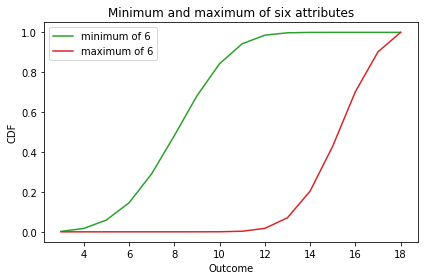

In [44]:
cdf_min6.plot(color='C2', label='minimum of 6')
cdf_max6.plot(color='C3', label='maximum of 6')
decorate_dice('Minimum and maximum of six attributes')
plt.ylabel('CDF')
savefig('fig06-03')

From the `Cdf` we can make the corresponding `Pmf`:

In [45]:
pmf_min6 = cdf_min6.make_pmf()

`Pmf` and `Cdf` provide `min_dist`, which does the same computation.
We can compute the `Pmf` of the minimum like this:

In [46]:
pmf_min_dist6 = pmf_4d6.min_dist(6)

And the `Cdf` of the minimum like this:


In [47]:
cdf_min_dist6 = cdf_4d6.min_dist(6)

And we can confirm that the differences are small.

In [48]:
np.max(np.abs(pmf_min_dist6 - pmf_min6))

0.0

In [49]:
np.max(np.abs(cdf_min_dist6 - cdf_min6))

0.0

In the exercises at the end of this notebook, you'll use distributions of the minimum and maximum to do Bayesian inference.
But first we'll see what happens when we mix distributions.

## Mixture

Let's do one more example inspired by *Dungeons & Dragons*.
Suppose I have a 4-sided die and a 6-sided die.
I choose one of them at random and roll it.
What is the distribution of the outcome?

If you know which die it is, the answer is easy.
A die with \py{n} sides yields a uniform distribution from 1 to \py{n}, including both.
We can compute \py{Pmf} objects to represent the dice, like this:

In [50]:
d4 = make_die(4)
d6 = make_die(6)

To compute the distribution of the mixture, we can compute the average of the two distributions by adding them and dividing the result by 2:

In [51]:
total = Pmf.add(d4, d6, fill_value=0) / 2
total

1    0.208333
2    0.208333
3    0.208333
4    0.208333
5    0.083333
6    0.083333
dtype: float64

We have to use \py{Pmf.add} with \py{fill_value=0} because the two distributions don't have the same set of quantities.
If they did, we could use the \py{+} operator.

Here's what the mixture of these distributions looks like.

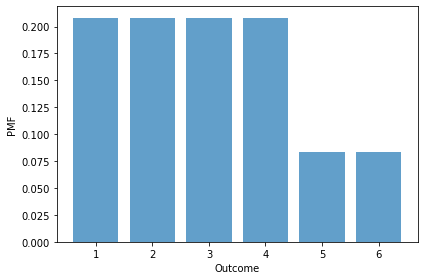

In [52]:
mix = Pmf(total)
mix.bar(alpha=0.7)
decorate_dice()

Now suppose I have a 4-sided die and *two* 6-sided dice.
Again, I choose one of them at random and roll it.
What is the distribution of the outcome?

We can solve this problem by computing a weighted average of the distributions, like this:

In [53]:
total = Pmf.add(d4, 2*d6, fill_value=0) / 3

Here's what it looks like.

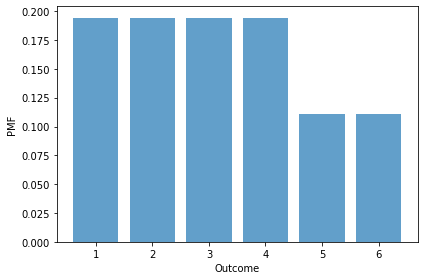

In [54]:
mix = Pmf(total)
mix.normalize()
mix.bar(alpha=0.7)
decorate_dice()

Finally, suppose we have a box with the following mix:

```
1  4-sided die
2  6-sided dice
3  8-sided dice
```

If I draw a die from this mix at random, we can use a \py{Pmf} to represent the hypothetical number of sides on the die:

In [55]:
hypos = [4,6,8]
counts = [1,2,3]
pmf_dice = Pmf(counts, hypos)
pmf_dice.normalize()
pmf_dice

,probs
4,0.166667
6,0.333333
8,0.500000


And I'll make a sequence of \py{Pmf} objects to represent the dice:

In [56]:
dice = [make_die(sides) for sides in hypos]

Now we have to multiply each distribution in \py{dice} by the corresponding probabilities in \py{pmf_dice}.
To express this computation concisely, it is convenient to put the distributions into a Pandas DataFrame:

In [57]:
pd.DataFrame(dice)

,1,2,3,4,5,6,7,8
0,0.250000,0.250000,0.250000,0.250000,NaN,NaN,NaN,NaN
1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,NaN,NaN
2,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125,0.125


The result is a DataFrame with one row for each distribution and one column for each possible outcome.
Not all rows are the same length, so Pandas fills the extra spaces with the special value \py{NaN}, which stands for ``not a number''.
We can use `fillna` to replace the \py{NaN} values with 0.

In [58]:
pd.DataFrame(dice).fillna(0)

,1,2,3,4,5,6,7,8
0,0.250000,0.250000,0.250000,0.250000,0.000000,0.000000,0.000,0.000
1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.000,0.000
2,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125,0.125


Before we multiply by the probabilities in \py{pmf_dice}, we have to transpose the matrix so the distributions run down the columns rather than across the rows:


In [59]:
df = pd.DataFrame(dice).fillna(0).transpose()
df

,0,1,2
1,0.25,0.166667,0.125
2,0.25,0.166667,0.125
3,0.25,0.166667,0.125
4,0.25,0.166667,0.125
5,0.00,0.166667,0.125
6,0.00,0.166667,0.125
7,0.00,0.000000,0.125
8,0.00,0.000000,0.125


Now we can multiply by the probabilities:


In [60]:
df *= pmf_dice.ps
df

,0,1,2
1,0.041667,0.055556,0.0625
2,0.041667,0.055556,0.0625
3,0.041667,0.055556,0.0625
4,0.041667,0.055556,0.0625
5,0.000000,0.055556,0.0625
6,0.000000,0.055556,0.0625
7,0.000000,0.000000,0.0625
8,0.000000,0.000000,0.0625


And add up the weighted distributions:


In [61]:
df.sum(axis=1)

1    0.159722
2    0.159722
3    0.159722
4    0.159722
5    0.118056
6    0.118056
7    0.062500
8    0.062500
dtype: float64

The argument \py{axis=1} means we want to sum across the rows.
The result is a Pandas Series.

Putting it all together, here's a function that makes a weighted mixture of distributions.

In [62]:
def make_mixture(pmf, pmf_seq):
    """Make a mixture of distributions.
    
    pmf: mapping from each hypothesis to its probability
    pmf_seq: sequence of Pmfs, each representing 
             a conditional distribution for one hypothesis
             
    returns: Pmf representing the mixture
    """
    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df *= pmf.ps
    total = df.sum(axis=1)
    return Pmf(total)

The first parameter is a \py{Pmf} that makes from each hypothesis to a probability.
The second parameter is a sequence of \py{Pmf} objects, one for each hypothesis.
We can call it like this:

In [63]:
mix = make_mixture(pmf_dice, dice)

And here's what it looks like.

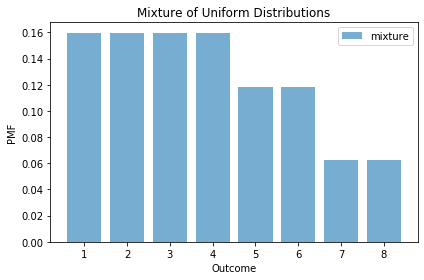

In [64]:
mix.bar(label='mixture', alpha=0.6)
decorate_dice('Mixture of Uniform Distributions')
savefig('fig06-04')

## Summary 

We have seen two representations of distributions: `Pmf` and `Cdf` objects.
These representations are equivalent in the sense that they contain
the same information, so you can convert from one to the other.  The
primary difference between them is performance: some operations are
faster and easier with a Pmf; others are faster with a Cdf.

In this chapter we used `Cdf` objects to compute distributions of maxima and minima; these distributions are useful for inference if we are given a maximum or minimum as data.

We also computed mixtures of distributions, which we will use in the next chapter to make predictions.

## Exercises

**Exercise:** When you generate a D&D character, instead of rolling dice, you can use the "standard array" of attributes, which is 15, 14, 13, 12, 10, and 8.

Do you think you are better off using the standard array or (literally) rolling the dice?

Compare the distribution of the values in the standard array to the distribution we computed for the best three out of four:

* Which distribution has higher mean?  Use the `mean` method.

* Which distribution has higher standard deviation?  Use the `std` method.

* The lowest value in the standard array is 8.  For each attribute, what is the probability of getting a value less than 8?  If you roll the dice six times, what's the probability that at least one of your attributes is less than 8?

* The highest value in the standard array is 15.  For each attribute, what is the probability of getting a value greater than 15?  If you roll the dice six times, what's the probability that at least one of your attributes is greater than 15?

To get you started, here's a `Cdf` that represents the distribution of attributes in the standard array:

In [65]:
standard = [15,14,13,12,10,8]
cdf_standard = Cdf.from_seq(standard)

We can compare it to the distribution of attributes you get by rolling four dice at adding up the best three.

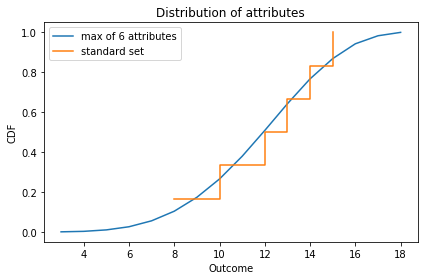

In [66]:
cdf_4d6.plot(label='max of 6 attributes')
cdf_standard.step(label='standard set')

decorate_dice('Distribution of attributes')
plt.ylabel('CDF');

I plotted `cdf_standard` as a step function to show more clearly that it contains only a few quantities.

In [67]:
# Solution

cdf_4d6.mean(), cdf_standard.mean()

(12.2714, 12.0)

In [68]:
# Solution

cdf_4d6.std(), cdf_standard.std()

(2.8301487664078717, 2.3804761428476167)

In [69]:
# Solution

cdf_4d6.lt_dist(8)

0.0556

In [70]:
# Solution

cdf_4d6.gt_dist(15)

0.13149999999999995

In [71]:
# Solution

cdf_min6.lt_dist(8), 1 - (1-cdf_4d6.lt_dist(8))**6

(0.29052700322827185, 0.29052700322827185)

In [72]:
# Solution

cdf_max6.gt_dist(15), 1 - (1-cdf_4d6.gt_dist(15))**6

(0.5708402963744774, 0.5708402963744774)

**Exercise:** Suppose I have a box with a 6-sided die, an 8-sided die, and a 12-sided die.
I choose one of the dice at random, roll it, and report that the outcome is a 1.
If I roll the same die again, what is the probability that I get another 1?

Hint: Compute the posterior distribution as we have done before and pass it as one of the arguments to `make_mixture`.

In [110]:
# Solution

hypos = [6, 8, 12]
prior = Pmf(1, hypos)
likelihood = 1/prior.qs
posterior = (prior * likelihood)
posterior.normalize()
posterior

,probs
6,0.444444
8,0.333333
12,0.222222


In [111]:
# Solution

d6 = make_die(6)
d8 = make_die(8)
d12 = make_die(12)

dice = d6, d8, d12

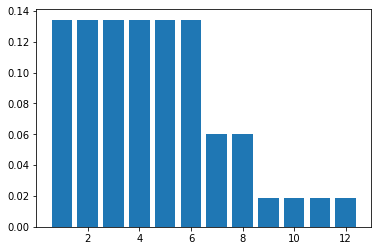

In [112]:
# Solution

mix = make_mixture(posterior, dice)
mix.bar()

In [113]:
# Solution

mix[1]

0.13425925925925924

**Exercise:**  Suppose I have two boxes of dice:

* One contains a 4-sided die and a 6-sided die.

* The other contains a 6-sided die and an 8-sided die.

I choose a box at random, choose a die, and roll it 3 times.  If I get 2, 4, and 6, which box do you think I chose?

In [103]:
# Solution

d4 = make_die(4)
d6 = make_die(6)
d8 = make_die(8)

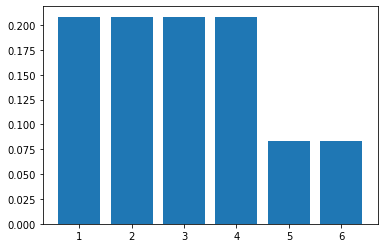

In [104]:
# Solution

pmf1 = Pmf(1/2, [4, 6])
mix1 = make_mixture(pmf1, [d4, d6])
mix1.bar()

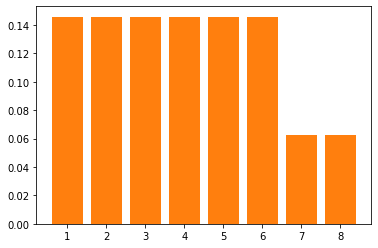

In [105]:
# Solution

pmf2 = Pmf(1/2, [6, 8])
mix2 = make_mixture(pmf2, [d6, d8])
mix2.bar(color='C1')

In [106]:
# Solution

data = [2, 4, 6]
mix1(data)

array([0.20833333, 0.20833333, 0.08333333])

In [107]:
# Solution

mix2(data)

array([0.14583333, 0.14583333, 0.14583333])

In [108]:
# Solution

likelihood = [mix1(data).prod(), mix2(data).prod()]
likelihood

[0.0036168981481481473, 0.003101490162037036]

In [109]:
# Solution

prior = Pmf(1/2, ['Box 1', 'Box 2'])
posterior = (prior * likelihood)
posterior.normalize()
posterior

,probs
Box 1,0.538358
Box 2,0.461642


**Exercise:** Henri Poincaré was a French mathematician who taught at the Sorbonne around 1900. The following anecdote about him is probably fabricated, but it makes an interesting probability problem.

Supposedly Poincaré suspected that his local bakery was selling loaves of bread that were lighter than the advertised weight of 1 kg, so every day for a year he bought a loaf of bread, brought it home and weighed it. At the end of the year, he plotted the distribution of his measurements and showed that it fit a normal distribution with mean 950 g and standard deviation 50 g. He brought this evidence to the bread police, who gave the baker a warning.

For the next year, Poincaré continued the practice of weighing his bread every day. At the end of the year, he found that the average weight was 1000 g, just as it should be, but again he complained to the bread police, and this time they fined the baker.

Why? Because the shape of the distribution was asymmetric. Unlike the normal distribution, it was skewed to the right, which is consistent with the hypothesis that the baker was still making 950 g loaves, but deliberately giving Poincaré the heavier ones.

To see whether this anecdote is plausible, let's suppose that when the baker sees Poincaré coming, he hefts `n` loaves of bread and gives Poincaré the heaviest one.  How many loaves would the baker have to heft to make the average of the maximum 1000 g?

To get you started, I'll generate a year's worth of data from a normal distribution with the given parameters.

In [73]:
mean = 950
std = 50
sample = np.random.normal(mean, std, size=365)

In [74]:
# Solution

cdf = Cdf.from_seq(sample)

for n in range(2, 6):
    cdf_max = cdf.max_dist(n)
    print(n, cdf_max.mean())

2 970.603341881204
3 984.605485580434
4 993.4050735673384
5 999.6625559587666


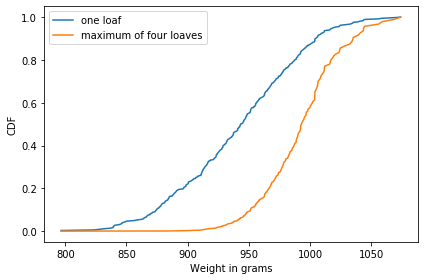

In [75]:
# Solution

cdf.plot(label='one loaf')
cdf.max_dist(4).plot(label='maximum of four loaves')

decorate(xlabel='Weight in grams',
         ylabel='CDF')

**Exercise:**  Two doctors fresh out of medical school are arguing about whose hospital delivers more babies.  The first doctor say, "I've been at Hospital A for two weeks, and already we've had a day when we delivered 20 babies."

The second doctor says, "I've only been at Hospital B for one week, but already there's been a 19-baby day."

Which hospital do you think delivers more babies on average?  You can assume that the number of babies born in a day is well modeled by a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) with parameter $\lambda$.

For a hypothetical value of $\lambda$, you can compute the PMF of a Poisson distribution like this:

In [76]:
from scipy.stats import poisson

def make_poisson(lam):
    high = np.round(lam * 4)
    qs = np.arange(0, int(high))
    ps = poisson(lam).pmf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

For example, if the actual value of $\lambda$ is 8, the distribution of babies born in a single day looks like this:

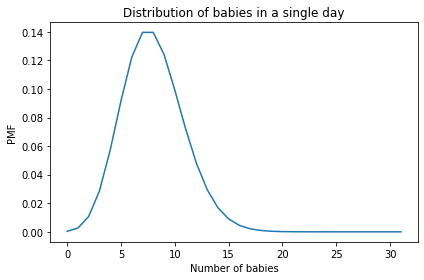

In [77]:
pmf = make_poisson(8)
pmf.plot()
decorate(xlabel='Number of babies', 
         ylabel='PMF',
         title='Distribution of babies in a single day')

The mean of this distribution is the parameter, $\lambda$.

In [78]:
pmf.mean()

7.999999996767771

And here's what the distributions look like for the maximum number of babies after one week or two weeks.

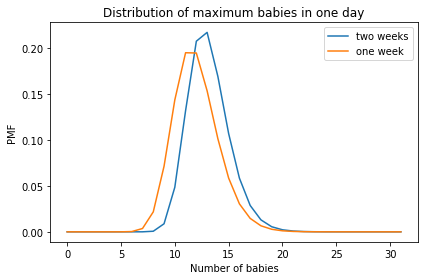

In [79]:
pmf_max = pmf.max_dist(2 * 7)
pmf_max.plot(label='two weeks')

pmf_max = pmf.max_dist(7)
pmf_max.plot(label='one week')

decorate(xlabel='Number of babies', 
         ylabel='PMF',
         title='Distribution of maximum babies in one day')

Now you finish it off from there.

In [80]:
# Solution

hypos = np.linspace(0, 25, 101)
prior = Pmf(1, hypos)

In [81]:
# Solution

days = 2 * 7
data = 20

likelihood1 = [make_poisson(hypo).max_dist(days)(data)
               for hypo in hypos]

In [82]:
# Solution

posterior1 = prior * likelihood1
posterior1.normalize()

3.245032091492791

In [83]:
# Solution

days = 7
data = 19

likelihood2 = [make_poisson(hypo).max_dist(days)(data)
               for hypo in hypos]

In [84]:
# Solution

posterior2 = prior * likelihood2
posterior2.normalize()

3.384498406074638

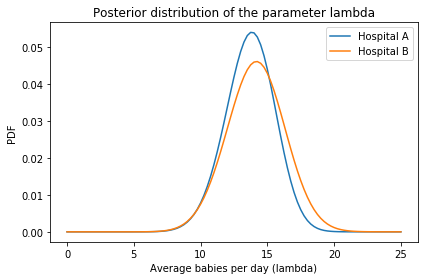

In [86]:
# Solution

posterior1.plot(label='Hospital A')
posterior2.plot(label='Hospital B')

decorate(xlabel='Average babies per day (lambda)', 
         ylabel='PDF',
         title='Posterior distribution of the parameter lambda')

In [ ]:
# Solution

posterior1.mean(), posterior2.mean()

**Exercise:**  This question is related to [a method I developed](https://patents.google.com/patent/US8385227B1/en) for estimating the minimum time for a packet of data to travel through a path in the internet.

Suppose I drive the same route three times and the fastest of the three attempts takes 8 minutes.

There are two traffic lights on the route.  As I approach each light, there is a 40% chance that it is green; in that case, it causes no delay.  And there is a 60% change it is red; in that case it causes a delay that is uniformly distributed from 0 to 60 seconds.

What is the posterior distribution of the time it would take to drive the route with no delays?

To get you started, here is the distribution of delays if the light is red.

In [87]:
qs = np.arange(1, 61)
pmf_delay = Pmf(1, qs)
pmf_delay.normalize()

60

And the distribution of delays if the light is green: always 0.

In [88]:
pmf_nodelay = Pmf.from_seq([0])
pmf_nodelay

,probs
0,1.0


Here is the mixture of delays due to red and green lights.

In [89]:
pmf = Pmf([0.4, 0.6])
pmf_total = make_mixture(pmf, [pmf_nodelay, pmf_delay])
pmf_total

,probs
0,0.40
1,0.01
2,0.01
3,0.01
4,0.01
...,...
56,0.01
57,0.01
58,0.01
59,0.01


Now I suggest the following steps:

1. Compute the distribution for the sum of two delays.

2. Compute the distribution for the lowest total delay after three attempts.

3. Make a prior distribution with a range of possible values for the no-delay travel time.

4. For each hypothesis, compute the likelihood of the observed minimum travel time, 8 minutes.

5. Compute the posterior distribution for the no-delay travel time.

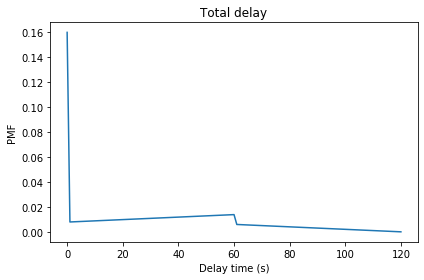

In [90]:
# Solution

twice = Pmf.add_dist(pmf_total, pmf_total)
twice.plot()
decorate(xlabel='Delay time (s)', 
         ylabel='PMF',
         title='Total delay')

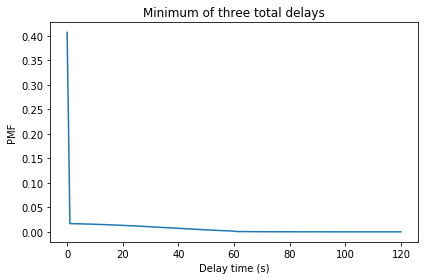

In [91]:
# Solution

twice_min3 = twice.min_dist(3)
twice_min3.plot()
decorate(xlabel='Delay time (s)', 
         ylabel='PMF',
         title='Minimum of three total delays')

In [97]:
# Solution

hypos = 8 * 60 - twice_min3.qs
prior = Pmf(1, hypos)

,probs
480,1
479,1
478,1
477,1
476,1
...,...
364,1
363,1
362,1
361,1


In [99]:
# Solution

data = 8 * 60
likelihood = [twice_min3.add_dist(hypo)(data)
              for hypo in hypos]

In [100]:
# Solution

posterior = prior * likelihood
posterior.normalize()

1.0

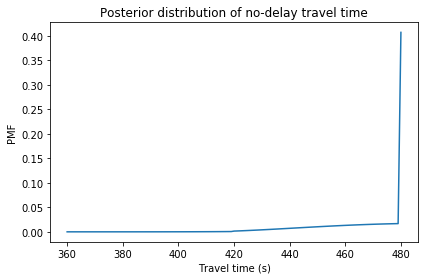

In [101]:
# Solution

posterior.plot()
decorate(xlabel='Travel time (s)', 
         ylabel='PMF',
         title='Posterior distribution of no-delay travel time')

In [102]:
# Solution

posterior.mean() / 60

7.777945555443998